In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import csv
import seaborn as sns
from textblob import TextBlob

# Preprosessing

In [19]:
class Preprocessing:
    def __init__(self, df, debug: bool = False, nan_threshold: int = 0.00):
        self._df = df
        self.debug = debug
        self.nan_threshold = nan_threshold
    
    def _set_dtypes(self):
        self._df['id'] = self._df['id'].astype('str')
        self._df['domain'] = self._df['domain'].astype('str')
        self._df['content'] = self._df['content'].astype('str')
        self._df['title'] = self._df['title'].astype('str')
        self._df['authors'] = self._df['authors'].astype('str') # maybe list of authors
        self._df['keywords'] = self._df['keywords'].astype('str') # maybe list of keywords
        self._df['meta_keywords'] = self._df['meta_keywords'].astype('str') # maybe list of meta_keywords
        self._df['meta_description'] = self._df['meta_description'].astype('str')
        self._df['tags'] = self._df['tags'].astype('str') # maybe list of tags
        self._df['summary'] = self._df['summary'].astype('str')
    
    def _remove_duplicates(self):
        self._df = self._df.drop_duplicates()

    def _remove_na(self):
        # Remove nulls from type column
        # df must contain the following fields: 
        # - domain 
        # - type 
        # - content 
        # - title 
        # - authors 
        
        self._df = self._df[
            (self._df['type'].notna()) & 
            (self._df['type'] != 'unknown') &
            (self._df['domain'].notna()) &
            (self._df['content'].notna()) &
            (self._df['title'].notna()) &
            (self._df['authors'].notna())
        ]

        def na_percentage_normalized(column):
            return self._df[column].isna().sum() / len(self._df[column])

        # Remove columns with more than self.nan_threshold NaN values
        for col in self._df.columns:
            na_percentage = na_percentage_normalized(col)
            if na_percentage > self.nan_threshold:
                self._df = self._df.drop(col, axis=1)
                if self.debug: print(f'Removed column [{col}] due to NaN percentage of {na_percentage:.2f}')

    
    def _remove_empty_strings(self):
        self._df = self._df[self._df['content'] != '']

    def _replace_nan(self):
        self._df = self._df.replace('nan', np.nan)
        self._df['meta_keywords'] = self._df['meta_keywords'].replace("['']", np.nan)
    
    def preprocess(self):
        self._set_dtypes()
        self._remove_duplicates()
        self._replace_nan()
        self._remove_na()
        self._remove_empty_strings()

        if self.debug: self.print_unique_values(['type'])
        
        return self._df
    
    def print_unique_values(self, columns: list = ['type']):
        for col in columns:
            print(f'Unique values for [{col}] out of {len(self._df[col])}: \n {self._df[col].value_counts()}')


In [20]:
def preprocess(df):
    preprocessing = Preprocessing(df, debug=True)
    df = preprocessing.preprocess()
    return df

In [21]:
def df_value_counts(df, columns: list = ['type']):
    for col in columns:
        print(f'Unique values for [{col}] out of {len(df[col])}: \n {df[col].value_counts()}')

# Loading the dataset

In [48]:
df = pd.read_csv(
    '../data/news/news_short.csv', 
    encoding='utf-8', 
    on_bad_lines='skip',
    lineterminator='\n',
    # quoting=csv.QUOTE_NONE,
    usecols=lambda column: column not in ['Unnamed: 0', 'source', 'scraped_at', 'inserted_at', 'updated_at', 'url']
)

TypeError: read_csv() got an unexpected keyword argument 'error_bad_lines'

# EDA

In [39]:
df

,,Advertisement Continue reading the main story
The Los Angeles City Council and the United States Olympic Committee will consider the agreement in August and,if it is approved,send it on to the I.O.C. for its vote in Sept...
The agreement is not without risks for Los Angeles.,NaN,NaN
The cost and logistical estimates that Los Angeles prepared in making its bid for the Games — and selling the idea to local officials and voters — were based on the event taking place in seven years. As officials here began contemplating the probability that Los Angeles would get the Games in 2028,they expressed concern about the entailing uncertainties; costs are likely to be higher than they would be in 2024.,NaN
Los Angeles’s plan depended on its sprawling system of stadiums and arenas — some left over from the 1984 Olympics,others belonging to major sports teams and university campuses — that in theory would keep construction costs low. The estimated cost is $5.3 billion,though city officials expected the funding to...
Newsletter Sign Up Continue reading the main story Please verify you're not a robot by clicking the box. Invalid email address. Please re-enter. You must select a newsletter to subscribe to. Sign Up You agree to receive occasional updates and special offers for The New York Times's products and services. Thank you for subscribing. An error has occurred. Please try again later. View all New York Times newsletters.,NaN,NaN
...,...,...
8951,9878292,nytimes.com
8952,9878293,nytimes.com
8953,9878294,nytimes.com
8954,9878295,nytimes.com


In [24]:
df = preprocess(df)

Removed column [keywords] due to NaN percentage of 1.00
Removed column [meta_keywords] due to NaN percentage of 0.05
Removed column [meta_description] due to NaN percentage of 0.00
Removed column [tags] due to NaN percentage of 0.93
Removed column [summary] due to NaN percentage of 1.00
Unique values for [type] out of 288149: 
 type
reliable    288149
Name: count, dtype: int64


In [25]:
df

,id,domain,type,content,title,authors
18,9519705,nytimes.com,reliable,Officials investigating the disappearance of a...,Man Suspected of Faking His Death Has Returned...,Michael Schwirtz
19,9519706,nytimes.com,reliable,Chase Austin will have a chance to become the ...,Foyt Picks Austin for Indy 500,The Associated Press
21,9519708,nytimes.com,reliable,But Zippy is quickly passing them as a star at...,A Horse That Enjoys the Spoils of Defeat,The Associated Press
22,9519709,nytimes.com,reliable,"CHARLESTON, W.Va. (AP) — Senator Robert C. Byr...",Byrd Got F.B.I. Documents on Civil Rights Move...,The Associated Press
23,9519710,nytimes.com,reliable,Photo\n\nLONDON — Who knew the best way to end...,Less Practice Equals More Medals for U.S. Divi...,Andrew Das
...,...,...,...,...,...,...
358456,9878292,nytimes.com,reliable,"Photo\n\nMan does not live by bread alone, it ...",Corruption With a Chance of Meatballs,Clyde Haberman
358457,9878293,nytimes.com,reliable,"VIX, which measures investor expectations that...","Volatility Rattles Stocks, and Investors Who B...",Landon Thomas Jr.
358458,9878294,nytimes.com,reliable,Housing Authority residents in the audience we...,"As 4 of 5 in Public Housing Lost Heat, a Deman...",William Neuman
358459,9878295,nytimes.com,reliable,"He has a curious way of expressing it, though....",Who Said It: Pepé Le Pew or Donald Trump?,Jennifer Finney Boylan


In [26]:
# get rows with NaN values
df[df.isna().any(axis=1)]

,id,domain,type,content,title,authors


In [27]:
df.to_csv('../data/news/preprocessed.csv', index=False)

#### Plots

In [28]:
def type_pie_chart(df): 
    # Assuming you have already created the DataFrame 'df' as described earlier

    # Count the occurrences of each 'type'
    type_counts = df['type'].value_counts()

    # Create a pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(type_counts, autopct='%1.1f%%', startangle=140)
    plt.title('Distribution of "type"')

    # Create a legend outside the circle
    plt.legend(type_counts.index, loc="center left", bbox_to_anchor=(0.75, 1))

    # Show the pie chart
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

In [29]:
def domain_pie_chart(df):
    # Count the occurrences of each domain
    domain_counts = df['domain'].value_counts()
    
    # Calculate the total count of domains
    total_domains = len(df)
    
    # Filter domains with more than 5% of the distribution
    threshold_percentage = 5.0
    filtered_domains = domain_counts[domain_counts / total_domains * 100 > threshold_percentage]
    
    # Group other domains under "Other" and calculate their count
    other_domains_count = total_domains - filtered_domains.sum()
    if other_domains_count > 0: 
        filtered_domains['Other'] = other_domains_count

   
    # Create a pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(filtered_domains, startangle=140, autopct='%1.1f%%')
    plt.legend(filtered_domains.index, loc="upper left")
    plt.title('Distribution of Domains (More than 5%)')
    
    # Show the pie chart
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

In [30]:
def domain_bar_chart(df):
    # Assuming your DataFrame is named 'df' with a 'domain' column
    domain_counts = df['domain'].value_counts().head(10)  # Display top 10 domains
    plt.bar(domain_counts.index, domain_counts.values)
    plt.xlabel('Domain')
    plt.ylabel('Count')
    plt.title('Top 10 Domains with the Most Articles')
    plt.xticks(rotation=10)  # Rotate x-axis labels for better readability
    plt.show()

In [31]:
def title_word_cloud(df): 
    # Create separate DataFrames for "fake" and "non-fake" news
    fake_news_df = df[df['type'] == 'fake']
    non_fake_news_df = df[df['type'] != 'fake']

    # Combine all text content into a single string for "fake" news
    fake_text = ' '.join(fake_news_df['title'].dropna())

    # Generate the word cloud for "fake" news
    wordcloud_fake = WordCloud(width=800, height=400, background_color='white').generate(fake_text)

    # Combine all text content into a single string for "non-fake" news
    non_fake_text = ' '.join(non_fake_news_df['title'].dropna())

    # Generate the word cloud for "non-fake" news
    wordcloud_non_fake = WordCloud(width=800, height=400, background_color='white').generate(non_fake_text)

    # Create subplots for both word clouds
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(wordcloud_fake, interpolation='bilinear')
    plt.axis('off')  # Remove axis
    plt.title('Word Cloud of Fake News Titles')

    plt.subplot(1, 2, 2)
    plt.imshow(wordcloud_non_fake, interpolation='bilinear')
    plt.axis('off')  # Remove axis
    plt.title('Word Cloud of Non-Fake News Titles')

    plt.tight_layout()
    plt.show()

In [32]:
def sentiment_scatter(df):
    def get_sentiment_polarity(text):
        analysis = TextBlob(text)
        return analysis.sentiment.polarity

    # Create DataFrames for "fake" and "non-fake" news
    fake_news_df = df[df['type'] == 'fake'].copy()
    non_fake_news_df = df[df['type'] != 'fake'].copy()

    # Calculate sentiment polarity for title and content for both DataFrames
    fake_news_df['title_sentiment'] = fake_news_df['title'].apply(get_sentiment_polarity)
    fake_news_df['content_sentiment'] = fake_news_df['content'].apply(get_sentiment_polarity)
    non_fake_news_df['title_sentiment'] = non_fake_news_df['title'].astype('str').apply(get_sentiment_polarity)
    non_fake_news_df['content_sentiment'] = non_fake_news_df['content'].apply(get_sentiment_polarity)

    # Calculate correlation between title and content sentiment for both DataFrames
    fake_correlation = fake_news_df[['content_sentiment', 'title_sentiment']].corr().iloc[0, 1]
    non_fake_correlation = non_fake_news_df[['content_sentiment', 'title_sentiment']].corr().iloc[0, 1]

    # Create scatter plots for "fake" and "non-fake" news with correlation in title
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(fake_news_df['content_sentiment'], fake_news_df['title_sentiment'], alpha=0.5)
    plt.xlabel('Content Sentiment')
    plt.ylabel('Title Sentiment')
    plt.title(f'Scatter Plot of Sentiment (Fake News)\nCorrelation: {fake_correlation:.2f}')

    plt.subplot(1, 2, 2)
    plt.scatter(non_fake_news_df['content_sentiment'], non_fake_news_df['title_sentiment'], alpha=0.5)
    plt.xlabel('Content Sentiment')
    plt.ylabel('Title Sentiment')
    plt.title(f'Scatter Plot of Sentiment (Non-Fake News)\nCorrelation: {non_fake_correlation:.2f}')

    plt.tight_layout()
    plt.show()

In [33]:
def sentiment_heatmap(df): 
    # Assuming your DataFrame 'df' has columns: 'type', 'title', and 'content'

    # Function to calculate sentiment polarity using TextBlob
    def get_sentiment_polarity(text):
        analysis = TextBlob(text)
        return analysis.sentiment.polarity

    # Define sentiment categories
    sentiment_categories = ["Negative", "Neutral", "Positive"]

    # Define sentiment discretization function
    def discretize_sentiment(polarity):
        if polarity < -1/3:
            return "Negative"
        elif -1/3 <= polarity <= 1/3:
            return "Neutral"
        else:
            return "Positive"

    # Create DataFrames for "fake" and "non-fake" news
    fake_news_df = df[df['type'] == 'fake'].copy()
    non_fake_news_df = df[df['type'] != 'fake'].copy()

    # Calculate sentiment polarity for title and content for both DataFrames
    fake_news_df['title_sentiment'] = fake_news_df['title'].apply(get_sentiment_polarity)
    fake_news_df['content_sentiment'] = fake_news_df['content'].apply(get_sentiment_polarity)
    non_fake_news_df['title_sentiment'] = non_fake_news_df['title'].astype('str').apply(get_sentiment_polarity)
    non_fake_news_df['content_sentiment'] = non_fake_news_df['content'].apply(get_sentiment_polarity)

    # Discretize sentiment into categories
    fake_news_df['title_sentiment_category'] = fake_news_df['title_sentiment'].apply(discretize_sentiment)
    fake_news_df['content_sentiment_category'] = fake_news_df['content_sentiment'].apply(discretize_sentiment)
    non_fake_news_df['title_sentiment_category'] = non_fake_news_df['title_sentiment'].apply(discretize_sentiment)
    non_fake_news_df['content_sentiment_category'] = non_fake_news_df['content_sentiment'].apply(discretize_sentiment)

    # Create pivot tables for the heatmaps and fill missing values
    pivot_fake = fake_news_df.pivot_table(index='title_sentiment_category', columns='content_sentiment_category', aggfunc='size', fill_value=0)
    pivot_fake = pivot_fake.reindex(columns=sentiment_categories, index=sentiment_categories, fill_value=0)

    pivot_non_fake = non_fake_news_df.pivot_table(index='title_sentiment_category', columns='content_sentiment_category', aggfunc='size', fill_value=0)
    pivot_non_fake = pivot_non_fake.reindex(columns=sentiment_categories, index=sentiment_categories, fill_value=0)

    # Create the subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot the heatmap for "fake" news
    sns.heatmap(pivot_fake, annot=True, fmt='d', cmap='coolwarm', cbar=True, ax=axes[0])
    axes[0].set_xlabel('Content Sentiment Category')
    axes[0].set_ylabel('Title Sentiment Category')
    axes[0].set_title('Sentiment Heatmap (Title vs. Content) - Fake News')

    # Plot the heatmap for "non-fake" news
    sns.heatmap(pivot_non_fake, annot=True, fmt='d', cmap='coolwarm', cbar=True, ax=axes[1])
    axes[1].set_xlabel('Content Sentiment Category')
    axes[1].set_ylabel('Title Sentiment Category')
    axes[1].set_title('Sentiment Heatmap (Title vs. Content) - Non-Fake News')

    plt.tight_layout()
    plt.show()

In [34]:
def nlp_exploratory_analysis(df): 
    """ 
        df must contain the following fields: 
            - domain 
            - type 
            - content 
            - title 
            - authors 
        
        Only these fields will be used for the exploratory analysis.
    """
    type_pie_chart(df)
    domain_pie_chart(df)
    domain_bar_chart(df)
    title_word_cloud(df)
    sentiment_scatter(df)
    sentiment_heatmap(df)

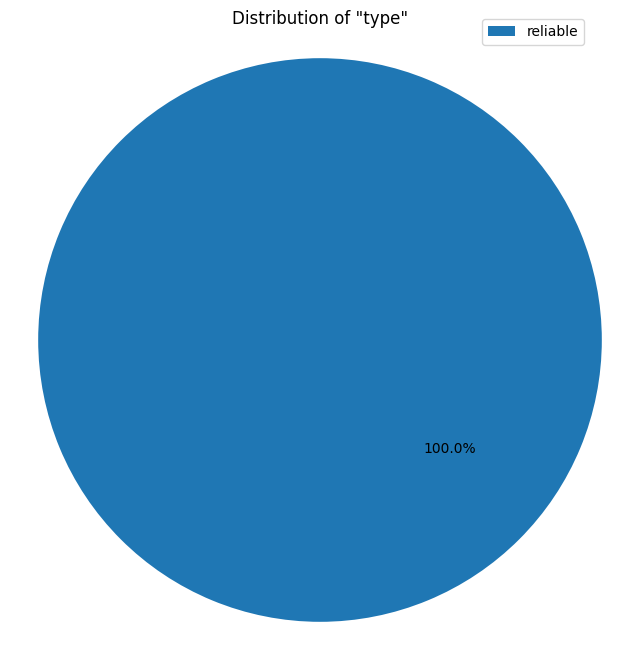

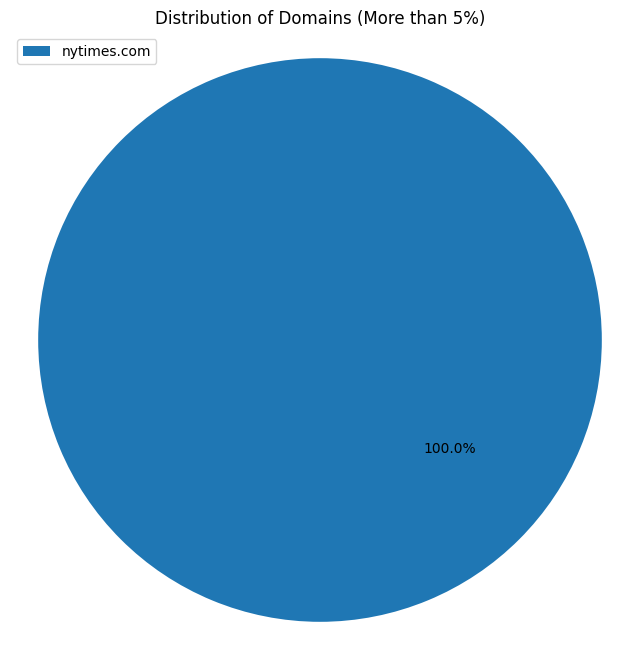

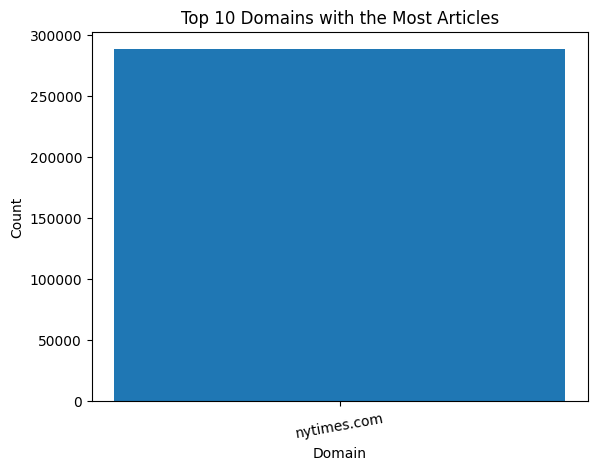

ValueError: We need at least 1 word to plot a word cloud, got 0.

In [35]:
nlp_exploratory_analysis(df)